# かがわAIゼミナール2019
## 課題2 : Car Fuel Consumption
## 100kmあたりのガソリン消費量(consume)を予測

#### DATA:kaggle    https://www.kaggle.com/anderas/car-consume

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV, SelectFromModel
# 決定木
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [2]:
# データ読み込み
df_data_csv = pd.read_csv("./car-consume/measurements.csv") 

display(df_data_csv.head())
df_data_csv.describe()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


,speed,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,41.927835,11.358247,0.077320,0.123711,0.082474
std,13.598524,6.991542,0.267443,0.329677,0.275441
min,14.000000,-5.000000,0.000000,0.000000,0.000000
25%,32.750000,7.000000,0.000000,0.000000,0.000000
50%,40.500000,10.000000,0.000000,0.000000,0.000000
75%,50.000000,16.000000,0.000000,0.000000,0.000000
max,90.000000,31.000000,1.000000,1.000000,1.000000


In [3]:
# distance : 距離km
# consume : 100kmあたりの消費リッター
# speed : 平均スピード
# temp_inside : エアコンの設定またはoffになっている場合は「Nan」
# temp_outside : 外気温
# specials : 雨、雪など気候変動がある場合は「AC」
# gas_type : 
# AC : one hot encoded, the special "AC". 1 for on, 0 for off
# rain : rain and snow is 1, good whather is 0

In [4]:
# データ型確認
df_data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null object
consume          388 non-null object
speed            388 non-null int64
temp_inside      376 non-null object
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null object
refill gas       13 non-null object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


In [5]:
# 行列数確認
df_data_csv.shape

(388, 12)

### データの整理（前処理）

- 小数点の文字を','を '.'に変換
- 欠損値Nanチェック
- カテゴリ変数をダミー変数に変換　gas_type
- 外れ値チェック

In [6]:
# 小数点についてドイツ形式の","から"."に変換
# distance, consume, temp_inside
df_data_csv['distance'] = df_data_csv['distance'].apply(lambda x: x.replace(",", ".")).astype(np.float)
df_data_csv['consume'] = df_data_csv['consume'].apply(lambda x: x.replace(",", ".")).astype(np.float)
df_data_csv['temp_inside'] = df_data_csv['temp_inside'].apply(lambda x: str(x).replace(",", ".")).astype(np.float)
df_data = df_data_csv
df_data.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


In [7]:
# 欠損値確認
print(df_data.isnull().sum())

distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64


temp_insideの欠損値を処理するにあたり、off時をどうするか
- 外気温とエアコンの温度差を出してみる →　説明変数の追加

In [8]:
df_data['temp_diff'] = abs(df_data['temp_inside'].astype(np.float32) - df_data['temp_outside'])

In [9]:
df_data["temp_diff"] = df_data["temp_diff"].fillna(0)

In [10]:
print(df_data.isnull().sum())

distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
temp_diff          0
dtype: int64


In [11]:
# temp_inside がNan値の行について追加した説明変数temp_diffの所が0埋めできていることを確認
df_data[pd.isnull(df_data['temp_inside'])]

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,temp_diff
93,12.4,4.7,43,NaN,10,NaN,SP98,0,0,0,NaN,NaN,0.0
95,11.8,5.3,52,NaN,11,NaN,SP98,0,0,0,NaN,NaN,0.0
97,15.7,5.3,33,NaN,9,NaN,SP98,0,0,0,NaN,NaN,0.0
98,12.9,5.7,35,NaN,9,NaN,SP98,0,0,0,NaN,NaN,0.0
99,6.4,4.4,37,NaN,10,NaN,SP98,0,0,0,NaN,NaN,0.0
100,5.3,4.1,34,NaN,9,NaN,SP98,0,0,0,NaN,NaN,0.0
102,18.8,5.0,62,NaN,9,rain,SP98,0,1,0,NaN,NaN,0.0
201,22.2,3.8,42,NaN,15,NaN,SP98,0,0,0,NaN,NaN,0.0
203,12.6,4.1,33,NaN,17,NaN,SP98,0,0,0,NaN,NaN,0.0
261,24.5,3.9,50,NaN,15,sun,E10,0,0,1,NaN,NaN,0.0


gas_type を0,1に変換する

In [12]:
# gas_typeを1:SP98, 0:E10 に変換
print(df_data['gas_type'].value_counts())

df_data['gas_type'] = np.where(df_data['gas_type'] == "SP98", 1, 0)


SP98    228
E10     160
Name: gas_type, dtype: int64


In [13]:
df_data.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,temp_diff
0,28.0,5.0,26,21.5,12,NaN,0,0,0,0,45,E10,9.5
1,12.0,4.2,30,21.5,13,NaN,0,0,0,0,NaN,NaN,8.5
2,11.2,5.5,38,21.5,15,NaN,0,0,0,0,NaN,NaN,6.5
3,12.9,3.9,36,21.5,14,NaN,0,0,0,0,NaN,NaN,7.5
4,18.5,4.5,46,21.5,15,NaN,0,0,0,0,NaN,NaN,6.5


In [14]:
df_data.describe()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,temp_diff
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.587629,0.077320,0.123711,0.082474,10.800258
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.492897,0.267443,0.329677,0.275441,6.031414
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000,6.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,1.000000,0.000000,0.000000,0.000000,11.500000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,1.000000,0.000000,0.000000,0.000000,14.625000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,1.000000,26.000000


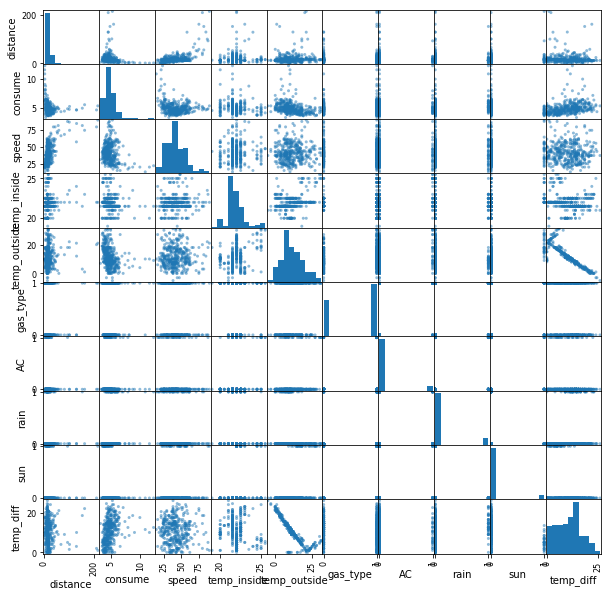

In [15]:
# 散布図行列
pd.plotting.scatter_matrix(df_data, figsize=(10,10))
plt.show()

→　temp_diff と temp_outside に強い相関が見られる。
speed と distance ／ temp と consume も相関が高い。

In [16]:
# 相関係数を確認
df_data.corr()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,temp_diff
distance,1.000000,-0.128967,0.562299,0.075305,0.088175,-0.053411,-0.025738,-0.019791,0.081120,-0.086600
consume,-0.128967,1.000000,-0.227866,-0.161991,-0.320811,-0.015327,0.096591,0.248118,-0.170667,0.315895
speed,0.562299,-0.227866,1.000000,0.059725,0.015411,-0.097360,-0.035408,0.009489,0.081618,-0.023726
temp_inside,0.075305,-0.161991,0.059725,1.000000,0.361308,0.010340,0.297775,-0.037356,0.246120,-0.150228
temp_outside,0.088175,-0.320811,0.015411,0.361308,1.000000,0.148705,0.167562,-0.186315,0.346903,-0.888989
gas_type,-0.053411,-0.015327,-0.097360,0.010340,0.148705,1.000000,0.105285,0.060328,0.022761,-0.151203
AC,-0.025738,0.096591,-0.035408,0.297775,0.167562,0.105285,1.000000,0.242915,0.088598,-0.053676
rain,-0.019791,0.248118,0.009489,-0.037356,-0.186315,0.060328,0.242915,1.000000,-0.112650,0.178797
sun,0.081120,-0.170667,0.081618,0.246120,0.346903,0.022761,0.088598,-0.112650,1.000000,-0.280140
temp_diff,-0.086600,0.315895,-0.023726,-0.150228,-0.888989,-0.151203,-0.053676,0.178797,-0.280140,1.000000


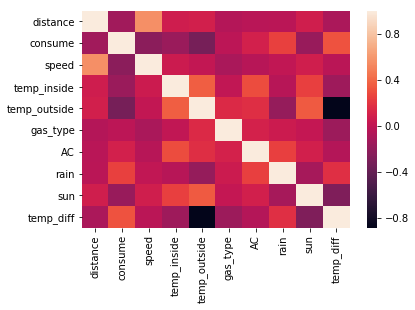

In [17]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_data.corr())
plt.show()

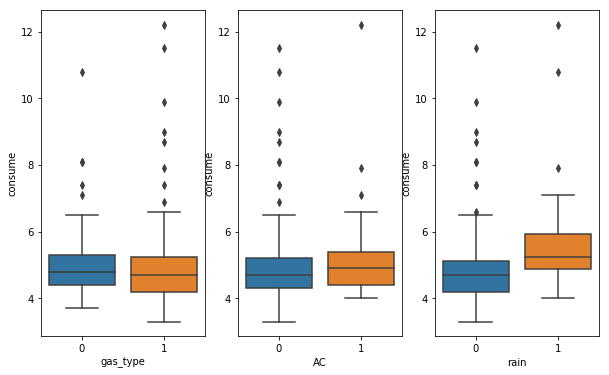

In [18]:
fig, ax = plt.subplots(1,3,figsize=(10,6))
sns.boxplot(x='gas_type', y='consume', data=df_data, ax=ax[0])
sns.boxplot(x='AC', y='consume', data=df_data, ax=ax[1])
sns.boxplot(x='rain', y='consume', data=df_data, ax=ax[2])

→　雨の日の方が平均的に燃費が良いことがわかる

## 線形回帰モデルを使って学習

In [19]:
# consumeとの関係が大きそうな３つを選択。speed, temp_diff, rain
# 係数を求める
y = df_data['consume'].values
X = df_data[['speed', 'temp_diff', 'rain']].values
# X = df_data[['speed', 'temp_diff', 'temp_outside', 'rain']].values
# 線形回帰
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]
# 変数の設定
x1 = X[:,0]
x2 = X[:,1]
x3 = X[:,2]

In [21]:
# 重み確認
y_est = w0 + w1 * x1 + w2 * x2 + w3 * x3
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}'.format(w0, w1, w2, w3))

w0 = 5.037, w1 = -0.017, w2 = 0.047, w3 = 0.630


In [22]:
# MSE, RMSE, MAEの確認
# 値を予測
y_pred = regr.predict(X)

# 平均二乗誤差 MSEを計算
mse = mean_squared_error(y, y_pred) 
print("MSE = %s"%round(mse,3) )  

# 平方根平均二乗誤差 RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

# 絶対値誤差 MAEを計算
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3) )

MSE = 0.865
RMSE = 0.93
MAE = 0.614


In [23]:
# MSE, RMSE, MAEを式でも確認
squared_error = 0.5 * np.sum((y - y_est) ** 2)
mean_squared_error_val = squared_error * 2 / len(y)
root_mean_squared_error_val = np.sqrt(mean_squared_error_val)
mean_absoluted_error_val = 0.5 * np.sum(abs(y - y_est)) * 2 / len(y)

print('MSE = {:.3f}'.format(mean_squared_error_val))
print('RMSE = {:.3f}'.format(root_mean_squared_error_val))
print('MAE = {:.3f}'.format(mean_absoluted_error_val))

MSE = 0.865
RMSE = 0.930
MAE = 0.614


### 説明変数を減らしてみる

'speed', 'temp_diff'の時

In [24]:
X = df_data[['speed', 'temp_diff']].values
# 線形回帰
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
# 変数の設定
x1 = X[:,0]
x2 = X[:,1]

# 重み確認
y_est = w0 + w1 * x1 + w2 * x2
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}'.format(w0, w1, w2))

# MSE, RMSE, MAEの確認
y_pred = regr.predict(X)
mse = mean_squared_error(y, y_pred) 
print("MSE = %s"%round(mse,3) )  
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3) )

w0 = 5.040, w1 = -0.017, w2 = 0.053
MSE = 0.907
RMSE = 0.952
MAE = 0.63


'speed', 'rain'の時

In [25]:
X = df_data[['speed', 'rain']].values
# 線形回帰
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
# 変数の設定
x1 = X[:,0]
x2 = X[:,1]

# 重み確認
y_est = w0 + w1 * x1 + w2 * x2
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}'.format(w0, w1, w2))

# MSE, RMSE, MAEの確認
y_pred = regr.predict(X)
mse = mean_squared_error(y, y_pred) 
print("MSE = %s"%round(mse,3) )  
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3) )

w0 = 5.549, w1 = -0.017, w2 = 0.784
MSE = 0.943
RMSE = 0.971
MAE = 0.659


'temp_diff', 'rain'の時

In [26]:
X = df_data[['temp_diff', 'rain']].values
# 線形回帰
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
# 変数の設定
x1 = X[:,0]
x2 = X[:,1]

# 重み確認
y_est = w0 + w1 * x1 + w2 * x2
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}'.format(w0, w1, w2))

# MSE, RMSE, MAEの確認
y_pred = regr.predict(X)
mse = mean_squared_error(y, y_pred) 
print("MSE = %s"%round(mse,3) )  
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3) )

w0 = 4.317, w1 = 0.048, w2 = 0.620
MSE = 0.918
RMSE = 0.958
MAE = 0.607


→　'speed', 'rain'の時が最も精度が高い。DAY１の説明変数３つ(speed, temp_outside, rain)の時の結果（MSE = 0.862、RMSE = 0.928、MAE = 0.619）と比較しても精度が良くなっている

In [27]:
X = df_data[['speed', 'rain']].values

## Day2 ホールドアウト法を試す

In [28]:
test_size = 0.1        # 全データのうち、何%をテストデータにするか（今回は10%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=123) 

In [29]:
# 学習用データを使って線形回帰モデルを学習
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train)

# 学習データに対するMAEを計算（訓練誤差の評価）
mae = mean_absolute_error(y_train, y_pred_train)
print("MAE = %s"%round(mae,3) )

MAE = 0.65


In [30]:
# テストデータに対する予測を実行
y_pred_test = regr.predict(X_test)

# テストデータに対するMAEを計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_pred_test)
print("MAE = %s"%round(mae,3) )

MAE = 0.678


(array([11., 55., 62., 94., 47., 46., 17.,  5.,  8.,  4.]),
 array([14. , 21.6, 29.2, 36.8, 44.4, 52. , 59.6, 67.2, 74.8, 82.4, 90. ]),
 <a list of 10 Patch objects>)

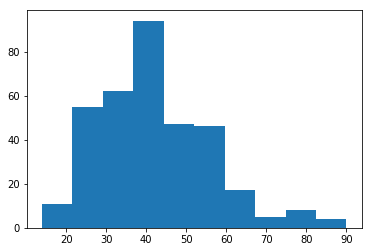

In [31]:
# まずは標準化する前の1つ目の特徴に関するヒストグラムを出してみる
plt.hist(X_train[:, 0]) # 学習用データ

### 標準化

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([11., 55., 62., 94., 54., 39., 17.,  5.,  8.,  4.]),
 array([-2.03624543, -1.48591556, -0.93558569, -0.38525581,  0.16507406,
         0.71540394,  1.26573381,  1.81606369,  2.36639356,  2.91672344,
         3.46705331]),
 <a list of 10 Patch objects>)

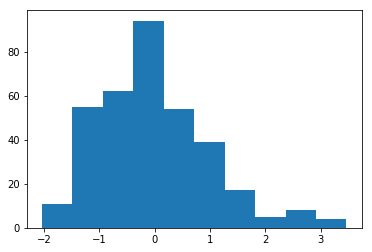

In [32]:
#標準化
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
plt.hist(X_train_std[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（学習用データ）

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([3., 7., 1., 3., 7., 7., 2., 1., 7., 1.]),
 array([-1.52936266, -1.23247417, -0.93558569, -0.6386972 , -0.34180871,
        -0.04492023,  0.25196826,  0.54885674,  0.84574523,  1.14263371,
         1.4395222 ]),
 <a list of 10 Patch objects>)

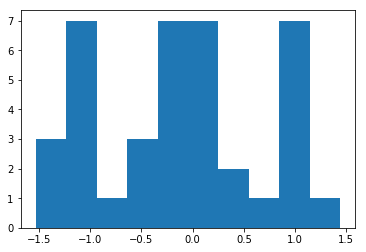

In [33]:
X_test_std = stdsc.transform(X_test)
plt.hist(X_test_std[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（テストデータ）

In [34]:
regr.fit(X_train_std, y_train)

# 学習用データに対する予測を実行
y_pred_train_std = regr.predict(X_train_std)

# 学習データに対するMAEを計算（訓練誤差の評価）
mae = mean_absolute_error(y_train, y_pred_train_std)
print("MAE = %s"%round(mae,3) )

MAE = 0.65


In [35]:
# テストデータに対する予測を実行
y_pred_test_std = regr.predict(X_test_std)

# テストデータに対するMAEを計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_pred_test_std)
print("MAE = %s"%round(mae,3) )

MAE = 0.678


### →　標準化する事で評価値（MAE）は変わらないが重みwを同じスケールで比較できるようになるメリットがある

## クロスバリデーション

In [36]:
n_split = 10 # グループ数を設定（今回は10分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=123).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.678

Fold 2
MAE = 0.507

Fold 3
MAE = 0.654

Fold 4
MAE = 0.713

Fold 5
MAE = 0.783

Fold 6
MAE = 0.722

Fold 7
MAE = 0.626

Fold 8
MAE = 0.834

Fold 9
MAE = 0.519

Fold 10
MAE = 0.684

Cross Validation MAE = 0.672


→　ホールドアウト法とあまり変わらない結果となった

ステップワイズ法による特徴選択

In [37]:
# estimatorにモデルをセット
# 今回は回帰問題であるためLinearRegressionを使用
estimator = LinearRegression(normalize=False)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=10, scoring='neg_mean_absolute_error')

In [38]:
df_data.columns

Index(['distance', 'consume', 'speed', 'temp_inside', 'temp_outside',
       'specials', 'gas_type', 'AC', 'rain', 'sun', 'refill liters',
       'refill gas', 'temp_diff'],
      dtype='object')

In [39]:
y = df_data['consume'].values
X = df_data[['distance','speed', 'temp_outside', 'gas_type', 'rain','temp_diff']].values

# fitで特徴選択を実行
rfecv.fit(X, y)

RFECV(cv=10,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring='neg_mean_absolute_error', step=1, verbose=0)

In [40]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[3 1 1 2 1 1]


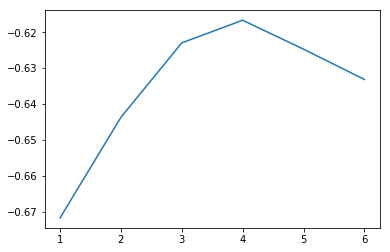

In [41]:
# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

→　概ね相関関係から選んだ特徴と同じような結果となった。

LASSOによる特徴選択

In [42]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [43]:
df_data_lasso = df_data[['consume','distance','speed', 'temp_outside', 'gas_type', 'rain','temp_diff']]

In [44]:
y = df_data_lasso['consume'].values
df_df_data_lasso_X = df_data_lasso.drop('consume', axis = 1)
X = df_df_data_lasso_X.values
# fitで特徴選択を実行
sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
        norm_order=1, prefit=False, threshold=1e-05)

In [45]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([False,  True,  True, False,  True,  True])

In [46]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
df_df_data_lasso_X.columns[removed_idx]

Index(['distance', 'gas_type'], dtype='object')

In [47]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([0.        , 0.01444126, 0.02303354, 0.        , 0.52359766,
       0.01859397])

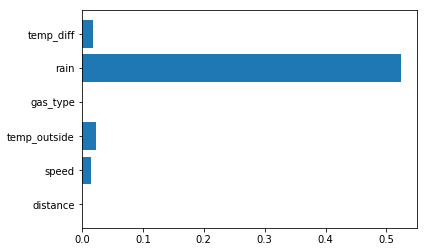

In [48]:
# 係数を棒グラフで表示
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=df_df_data_lasso_X.columns.values)
plt.show()

rain が最も高い

## 決定木

In [49]:
y = df_data['consume'].values
X = df_data[['speed', 'rain']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=123) 

決定木のグリッドサーチ

In [50]:
clf_tree = DecisionTreeRegressor(random_state=123)

In [51]:
param_grid = {"max_depth": [2,4,6,8,10], "criterion": ["mse", "mae"], "splitter":["best", "random"]}

In [52]:
tree_grid = GridSearchCV(clf_tree, param_grid = param_grid, cv=10)

tree_grid.fit(X_train, y_train) #fit
print(tree_grid.best_params_, tree_grid.best_score_)

{'criterion': 'mse', 'max_depth': 4, 'splitter': 'best'} 0.0742645277076653


In [53]:
clf = DecisionTreeRegressor(criterion="mae", max_depth=4, splitter="random", random_state=123)
clf = clf.fit(X_train, y_train)

In [54]:
clf.score(X_train, y_train)

0.2595998861341222

In [55]:
clf.score(X_test, y_test)

0.1445136976373389